In [24]:
#As always, we import everything
import pandas as pd
import os
import re
import hdf5_getters as getters
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords as stop_words
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib as plt
import json
import pickle
import lyricfetcher
import csv
import urllib
from urllib.request import urlopen, HTTPError

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Slim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# README

For the data collection, we have based ourselves on the Million Song Dataset. From this huge data, we are only interested in four attributes:
- The track id
- The artist name
- The year
- The title

In addition to that, we are also interested in the genre of the songs. Luckily, in the Million Song Dataset website, there is already a dataset with the track id and the genre. Thus, we downloaded the corresponding file. We have the genre information for around 191'000 songs. Moreover, we have direct access to the 4 attributes through an additional dataset of around 500'000 songs provided in the Million song website. 

We decide to limit our analysis on this dataset for two reasons. First, manipulating the whole million songs dataset is both time consuming and would require the use of the cluster. Second, after a fast and simple instruction, we discovered that around 150'000 of the genre id are already in the subset we have found.

Next, we use some APIs to scrap and collect the lyrics on several websites. However, we could not scrape all of our dataset so far, as one scraping operation takes more than 1 second. The whole scraping of the full set would take more than 55 hours, so we will have to find a method to perform it. The success rate of the scraping code on the 200 more recent songs of the data set was 129/200, which is fair but can still be raised by doing more string processing, for instance removing the "(live)" or "(album version)" strings. For the oldest songs, the success of the scraping is near 0, as the old songs are not usually found in the lyrics websites. This is not a major problem since as shown in our analysis later, the vast majority of the songs are recent ones.
Alternatively, we can use an additional dataset from the million song website containing bag of words data. We would like to avoid this alternative as it is a simple count of words in the songs and it removes them from the context in the songs.

In our notebook, we have performed a first descriptive analysis of the merged datasets. The big proportion ( 41%) of the songs' genre is rock. Moreover, although the values of the year attribute range from 1920 to 2010, 91% of the tracks are from the 1980 to 2010. We believe this is due to the rapid growth of Rock from its birth in the fifties to achieve more than 50% of the music industry in the 70s to 80s. In our notebook, we have a plot showing this evolution. In our analysis, due to the genre unbalance, we will use a random subset of the rock music ( or the decade) to balance out the classes.

# Data Collection and Descriptive Analysis

In [2]:
data_dir = './' + 'data'

Using an additional dataset obtained from the million song website that contains genre information, we created genre_dataset. This dataset contains genre information for 191401 songs. The cell below contains code for putting this data into a proper-formatted dataframe. Another helpful dataset obtained from the website of million song dataset is one that contains year the track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This dataset contains 515576 data points. Since we wanted to analyze the progression of feminism through lyrics over time, and we were also interested in how women were portrayed in different genres of music, we decided to take the intersection of these datasets (inner join on track ID), and the resulting data frame contains 152793 data points. We save it to a csv file for accessing in the future. 

In [3]:
# Resulting Dataset
year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
year_artist_name_title_genre.head()

,year,artist_name,title,genre
track_id,,,,
TRSGHLU128F421DF83,1922,alberta hunter,don't pan me,Blues
TRRAHXQ128F42511FF,1922,barrington levy,looking my love,Reggae
TRFAFTK12903CC77B8,1922,barrington levy,warm and sunny day,Reggae
TRTRKSF12903CFEDD7,1924,vernon dalhart,wreck of the old 97,Country
TRQYSYF128F935F350,1925,bessie smith,careless love blues,Blues


In [5]:
year_artist_name_title_genre.isna().sum()

year           0
artist_name    0
title          0
genre          0
dtype: int64

No missing values !

We are interested in seeing how many songs are present in each genre. 

In [6]:
print(year_artist_name_title_genre['genre'].value_counts())

# Visualizing the count using bar graph
value_count_by_genre = year_artist_name_title_genre['genre'].value_counts().plot(kind = 'bar')
value_count_by_genre

Rock          62344
Electronic    18043
Pop           11058
Jazz          10662
Rap            8156
Metal          8035
RnB            7692
Country        6652
Reggae         5475
Blues          4228
Folk           3484
Punk           2739
Latin          1954
World          1384
New Age         887
Name: genre, dtype: int64


In [7]:
# Percentage of rock songs in the dataset

round(100*year_artist_name_title_genre['genre'].value_counts()['Rock']/year_artist_name_title_genre['genre'].value_counts().sum(),3)

40.803

We see an abundance of Rock music in this dataset as close to half of the songs (40.8 %) present are labelled as Rock music. We wonder why that is. Is Rock Music more likely to get labelled? (<- this is a joke). We suspect that this is due to the fast growth of Rock music during the 1990s and 2000s. We will explore the relationship between year and genre of music further to confirm our hypothesis. 

Let us first have a look at the count of music by time. Since it is impossible to visualize the count for every single year, we first group years into decades. Upon quick analysis we realize that the dataset contains music up to the year 2010. We consider 2010 a part of the 2000s. 

In [8]:
# create decade column
year_artist_name_title_genre['decade'] = (year_artist_name_title_genre['year'] // 10) * 10

# include year 2010 in the 2000s decade
year_artist_name_title_genre['decade'] = np.where(year_artist_name_title_genre.year.isin(['2010']),'2000', 
                                                  year_artist_name_title_genre['decade'])

In [9]:
round(100*(year_artist_name_title_genre['decade'].value_counts()['2000'] + \
year_artist_name_title_genre['decade'].value_counts()['1990'] + \
year_artist_name_title_genre['decade'].value_counts()['1980']) / \
year_artist_name_title_genre['decade'].value_counts().sum(),3)

91.361

91% of the tracks are from the eighties to 2010

2000    89699
1990    36693
1980    13201
1970     8340
1960     3580
1950      944
1940      138
1930      111
1920       87
Name: decade, dtype: int64


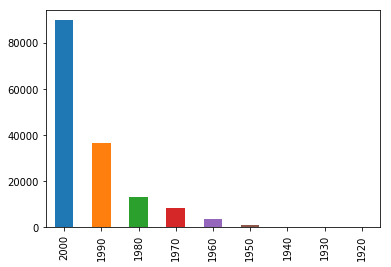

In [10]:
# plot count using bar plot
value_count_by_year = year_artist_name_title_genre['decade'].value_counts().plot(kind = 'bar')

print(year_artist_name_title_genre['decade'].value_counts())
value_count_by_year

We see that there are very few data points earlier than 1970, which makes analysis over time biased. During the next few steps as we explore the relationship between genre and decade further, we only consider the time period of 1970 to 2010. 

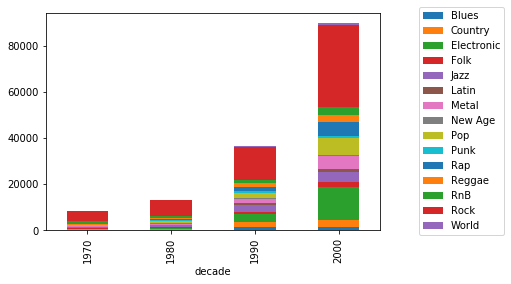

In [11]:
decade_genre = year_artist_name_title_genre[['decade', 'genre']].reset_index()

decade_genre = decade_genre.loc[decade_genre['decade'].isin(['1970','1980','1990','2000'])]

#print(decade_genre.groupby(['decade', 'genre']).size())
plot_decade_genre = decade_genre.groupby(['decade', 'genre']).size().unstack().plot(kind='bar', stacked = True)
plot_decade_genre.legend(bbox_to_anchor=(1.1, 1.05) )


We see that Rock music grew significantly in 40 years. Rock, Electronic, and Pop are the most popular music during the 2000s, followed by metal and Rap. The next plot considers the genres individually, and illustrates their share in the music market over the period of 1970 to 2010. 

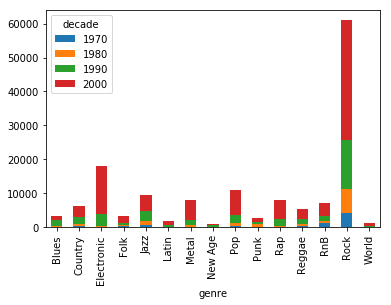

In [12]:
#print(decade_genre.groupby(['genre', 'decade']).size())
decade_genre.groupby(['genre', 'decade']).size().unstack().plot(kind='bar', stacked = True)

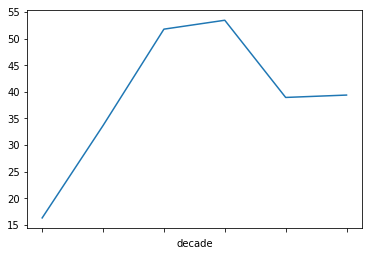

In [13]:
# Evolution of Rock

decade_rock = year_artist_name_title_genre.groupby(['genre','decade']).size()
(100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())).plot()


The plot is a bitt hard to read. The curve represents the percentage of rock tracks in our dataset through time. We can clearly see that it has increased drastically from the 60s to 2010. We believe that the slight decrease from 90s is due to the increasing success of RNB, rap, pop and Electronic music during that period.

In [14]:
100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())

decade
1920          NaN
1930          NaN
1940          NaN
1950    16.313559
1960    33.659218
1970    51.762590
1980    53.435346
1990    38.936582
2000    39.383940
dtype: float64

# Using the Bag of words model from musicXmatch

In [15]:
# We read the text file line by line 

with open(os.path.join(data_dir, 'mxm_dataset_train.txt')) as f:
    lines = f.readlines()

In [16]:
# The 5'000 most used words sorted by overall occurences are in the 18th line. 
# We split the words by ',' to have a list of words

words = lines[17][1:]
words = words.split(',')

In [17]:
words[0:4]

['i', 'the', 'you', 'to']

Now, for the rest of the file, we have, for each line, a track id and a list of tuplets. A tuplet ( key:value) consists of:
 - a key ( a number ) which represents the identifier of the word ( 1 means the 1st word in our words list etc ).
 - a value which is the occurences of the word in the track.
 
In the following cells, we extract this information and we change the numbered keys to "word keys"

In [18]:
# First, we split to have a list of tracks

bow = lines[18:]
for i in range(0,len(bow)):
    bow[i] = bow[i].split(',')

In [69]:
# Uncomment this cell to have a look at the split data
# Warning, it takes a lot of space in the cell

# bow[1:4]

For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':') then replace it by the corresponding word

In [19]:
for i in range(0,len(bow)):
    for j in range(2,len(bow[i])):
        '''
        For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':')
        then replace it by the corresponding word
        '''
        key = bow[i][j][ 0 : bow[i][j].find(':') ]
        bow[i][j] = bow[i][j].replace(key,words[int(key)-1])
    # The last tuplet in each track has a line skip special character.
    # The next code will take the last tuplet with the special character
    bow[i][len(bow[i])-1] = bow[i][len(bow[i])-1][0:len(bow[i][len(bow[i])-1])-1]

In [20]:
# Extract the track id 

track_id = []
for i in range(0, len(bow)):
    track_id.append(bow[i][0])

# Lyrics scrapping code

In [21]:
def scrape_lyrics(artists_list,songs_list):
    '''
    Main scrapping function
    Input: lists of songs and their artists names 
    Output: list of lyrics of the songs and list of songs for which the scrapping did not succeed
    In case the scrapping failed, lyrics are returned as empty strings
    
    The lyrics are scrapped from several websites:
    - metrolyrics
    If failed:
    -azlyrics
    If failed also:
    - lyricswikia
    And if it also failed:
    - through the herokuapp online API (unknown source)
    
    '''
    
    lyrics_not_found = []
    if (len(artists_list) == 0 or len(songs_list) == 0):
        raise ValueError('The provided artists list or songs list is empty')
        
    elif (len(artists_list) != len(songs_list)):
        print("artist list has len: ", len(artists_list))
        print("songs list has len: ", len(songs_list))
        raise ValueError('The provided artists and songs lists have different lenghts')
        
    else:
        lyrics = []
        
        for i in tqdm(range(len(artists_list))):
            try:
                lyrics_metro = str(lyricfetcher.get_lyrics('metrolyrics',artists_list[i],songs_list[i]))
                lyrics_metro = re.sub(r'[\[].*?[\]]', '', lyrics_metro.replace('\n', ' '))
                lyrics_metro = re.sub(',', '', lyrics_metro)

                if (lyrics_metro == "" or len(lyrics_metro.split())<3):
                    lyrics_az = str(lyricfetcher.get_lyrics('azlyrics',artists_list[i],songs_list[i]))
                    lyrics_az = re.sub(r'[\[].*?[\]]', '', lyrics_az.replace('\n', ' '))
                    lyrics_az = re.sub(',', '', lyrics_az)

                    if (lyrics_az == "" or len(lyrics_az.split())<3):
                        lyrics_wikia = str(lyricfetcher.get_lyrics('lyricswikia',artists_list[i],songs_list[i]))
                        lyrics_wikia = re.sub(r'[\[].*?[\]]', '', lyrics_wikia.replace('\n', ' '))
                        lyrics_wikia = re.sub(',', '', lyrics_wikia)
                        
                        if (lyrics_wikia == "" or len(lyrics_wikia.split())<3):
                            try:
                                lyrics_herokuapp = json.load(urllib.request.urlopen('http://lyric-api.herokuapp.com/api/find/' 
                                                                                + artists_list[i].replace(' ', '%20') + '/' 
                                                                                + songs_list[i].replace(' ', '%20') + '.html'))['lyric']
                            except HTTPError:
                                lyrics_herokuapp = ''
                                
                            lyrics_herokuapp = re.sub(r'[\[].*?[\]]', '', lyrics_herokuapp.replace('\n', ' '))
                            lyrics_herokuapp = re.sub(',', '', lyrics_herokuapp)
                            
                            if (lyrics_herokuapp == "" or len(lyrics_herokuapp.split())<3):
                                lyrics.append("")
                                raise ValueError('No lyrics OR lyrics smaller or equal to 2 words found')
                                
                            else:
                                lyrics.append(lyrics_herokuapp)
                        else:
                            lyrics.append(lyrics_wikia)
                    else:
                        lyrics.append(lyrics_az)

                else:
                    lyrics.append(lyrics_metro)
                    
            except ValueError:
                lyrics_not_found.append([artists_list[i],songs_list[i]])
                continue
    return lyrics, lyrics_not_found

In [24]:
'''
Gets track ids already in csv file
Avoid scraping lyrics when already attempted (if track id already in the csv file)
New track ids and lyrics will be added rows BELOW the actual csv file, without deleting actual lyrics
'''

lyrics_csv_filename = os.path.join(data_dir + "/lyrics_year_genre.csv")

check_for_already_scrapped = False # Set true or false

if check_for_already_scrapped:
    with open(lyrics_csv_filename, "r") as f:
        reader = csv.reader(f)
        try:
            track_id_csvfile = next(reader)
        except StopIteration:
            track_id_csvfile = []
            
else:
    f = open(lyrics_csv_filename, "w")
    f.truncate()
    f.close()
    track_id_csvfile = []
        
print(track_id_csvfile)

[]


In [22]:
'''
Gets track ids already in csv file
Avoid scraping lyrics when already attempted (if track id already in the csv file)
New track ids and lyrics will be added rows BELOW the actual csv file, without deleting actual lyrics
'''

lyrics_csv_filename = os.path.join(data_dir + "/feminism_playlist.csv")


In [22]:
# compute list 'difference' in the sense of objects that are present in one list but not in the other one
def diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

In [26]:
csv.field_size_limit(100000000)

lyrics_list = []
with open(data_dir+"/feminism_playlist.csv", "rt") as f:
    reader = csv.reader(f, delimiter="\t")
    for line in reader:
        lyrics_list += line
lyrics_list = lyrics_list[2]
lyrics_list

tokens = nltk.word_tokenize(lyrics_list)

from nltk.stem import PorterStemmer

ps = PorterStemmer()
stemmed_tokens = [ps.stem(token) for token in tokens] 

len(stemmed_tokens)

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
filtered_sentence = [] 
  
for w in stemmed_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w)
        
filtered_sentence

from collections import Counter
counts = Counter(filtered_sentence)
counts.most_common(100)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 1070: character maps to <undefined>

In [26]:
# From https://www.telegraph.co.uk/women/life/hag-harridan-crone-16-words-use-describe-older-women/

degrading_terms = ["battleaxe","bint","cougar","crone","frump",
                   "hag","harridan","hormonal","matronly","milf",
                   "mutton","bag","shrill","spinster","wench","witch"]

# From https://en.wikipedia.org/wiki/Category:Misogynistic_slurs

degrading_terms = degrading_terms + ["becky","bitch","boseulachi","cock","crone","cunt","doenjang",
                                     "poop","dyke","hag","harpy","slut","slut-shaming","squaw",
                                     "termagant","tranny","twat","virago","zhyd"]

# From https://en.wikipedia.org/wiki/Category:Slang_terms_for_women

degrading_terms = degrading_terms + ["yummy","trixie","butch","skintern","kitten","ratchet","moll"]

# From https://www.macmillandictionary.com/thesaurus-category/british/insulting-words-for-a-woman

degrading_terms = degrading_terms + ["witch","virago","frump","harridan","bird","candy","wench","girly"]

# Inspiration from https://sites.google.com/site/hiphopmusiclyrics/top-10-degrading-songs-towards-women

degrading_terms = degrading_terms + ["vagina","ass","shit","hole","dick","pussy"]

# From http://onlineslangdictionary.com/lists/most-vulgar-words/

degrading_terms = degrading_terms + ["cock-juggling","sucker","cumdump","assmucus","fucktoy","cuntee",
                                     "gangbang","fugly","fubugly","puppet","fuck-bitch"]

# From https://en.wiktionary.org/wiki/Appendix:English_sexual_slurs

degrading_terms = degrading_terms + ["ballbreaker","ballbuster","beef","clientapollas","changa","crow",
                                     "dog","dyke","fag","fish","minger","muffdiver","munter","pillow-biter",
                                     "skank","streetwalker","swallower","tabby","teaser","thais",
                                     "thespian","third-legger","thot","tickle-tail","whore"]

# From https://ht.ac.uk/category/?type=search&word=women#id=39814

degrading_terms = degrading_terms + ["carline","female","rib","biddy","judy","heifer","hay-bag","bint","tart",
                                     "babe","muff","lubra"]

# From https://www.huffingtonpost.ca/2013/09/10/offensive-words_n_3581599.html

degrading_terms = degrading_terms + ["buttaface","fashionista","mompreneut","wifey","sidebook","booty","feisty",
                                     "shrill","sweetie","honey-bun"]

# From https://www.telegraph.co.uk/women/life/ambitious-frigid-and-frumpy-25-words-we-only-use-to-describe-wom/

degrading_terms = degrading_terms + ["bombshell","bossy","bridezilla","bubbly","silly","ditsy","frigid","hormonal",
                                    "high-maintenance","hysterical","sassy","shrill","whinging"]

# From http://onlineslangdictionary.com/thesaurus/words%2Bmeaning%2Bwoman%2C%2Bwomen%2C%2Bfemale.html

degrading_terms = degrading_terms + ["candy","beast","beav","biddie","biddy","bimbo","bimho","bint","bisnotch",
                                     "breezie","breezy","bushpig","butterface","butterhead","chank","chica","chicadee","hoochie",
                                     "cow","crockadillapig","cronk","ditz","doll","dudette","fem-fetale","filly",
                                     "flange","flipper","floozie","floozy","foxy","gilf","heina","gyal","hoe","hogbeast","homegirl",
                                     "hooch","girl","hoochie","hoss","hunny","hussy","huzzie","savage","jumper","jumpoff","karena","lass",
                                     "lolita","lumberjack","ma'am","mami","manizer","manster","mif","millihelen","minger","mole","moll",
                                     "mudpout","poon","poontang","prostitot","pyt","queenpin","ragamuffin","rasp","rat","rub","sauerkraut","scud",
                                     "kitten","mama","shwaty","sheila","sista","skank","sorostitute","split-tail","toots","tramp","whooty","womyn","yak"]

# From https://www.thesaurus.com/browse/slut

degrading_terms = degrading_terms + ["harlot","prostitue","hooker","tart","floozy","vamp","escort","strumpet","hustler"]

degrading_terms = list(set(degrading_terms))

print(degrading_terms)

['hooch', 'clientapollas', 'thais', 'witch', 'gilf', 'lolita', 'gyal', 'ass', 'butterface', 'dudette', 'crockadillapig', 'mutton', 'cock-juggling', 'harridan', 'cumdump', 'toots', 'trixie', 'changa', 'sidebook', 'hogbeast', 'buttaface', 'yummy', 'foxy', 'tramp', 'prostitot', 'sorostitute', 'mami', 'cunt', 'shwaty', 'swallower', 'dog', 'honey-bun', 'flipper', 'chank', 'third-legger', 'bint', 'doenjang', 'mompreneut', 'lass', 'cuntee', 'hormonal', 'fugly', 'hag', 'sweetie', 'breezy', 'sauerkraut', 'butterhead', 'sheila', 'muff', 'queenpin', 'shit', 'harlot', 'spinster', 'becky', 'slut-shaming', 'female', 'filly', 'biddy', 'homegirl', 'poop', 'mif', 'slut', 'lumberjack', 'floozy', 'rat', 'whinging', 'tart', 'silly', 'whore', 'chicadee', 'squaw', 'poontang', 'muffdiver', 'shrill', 'bisnotch', 'sucker', 'bimho', 'fubugly', 'heifer', 'whooty', 'millihelen', 'pussy', 'ragamuffin', 'ballbreaker', 'cronk', 'streetwalker', 'cougar', 'manizer', 'pyt', 'high-maintenance', 'biddie', 'hussy', 'manst

In [27]:
negative_score = []

for i in range(0,len(bow)):
    neg_song=0
    for j in range(2,len(bow[i])):
        word = bow[i][j]
        key = word[ 0 : word.find(':') ]
        if(key in degrading_terms):
            occurence = word[word.find(':')+1:]
            neg_song += int(occurence)
    negative_score = negative_score + [bow[i][0],neg_song]
    

In [28]:
dist = []
for i in range(1,len(negative_score),2):
    dist.append(negative_score[i])

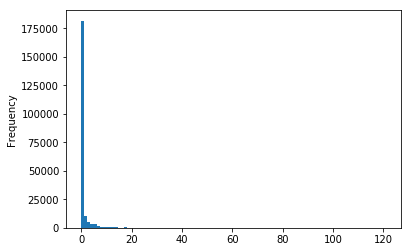

In [29]:
pd.Series(dist).plot(kind='hist', bins = 100)

In [30]:
for i in range(0,len(words)):
    if(words[i] in degrading_terms):
        print(words[i])

girl
shit
mama
dog
bird
bitch
babe
hole
ass
bag
beast
fish
hoe
dick
whore
rat
lass
doll
sucker
witch
crow
cock
rub
chica
cow
mami
puppet
slut
beef
cunt


In [36]:
'''
Gets track ids already in csv file
Avoid scraping lyrics when already attempted (if track id already in the csv file)
New track ids and lyrics will be added rows BELOW the actual csv file, without deleting actual lyrics
'''

lyrics_csv_filename = os.path.join(data_dir + "/feminism_playlist.csv")

In [28]:
#Provide BELOW the full set of tracks you would like to get in final (XXX_to_scrape)
#-----------------------------------------------------------------------------
artists_to_scrape = ["Sugababes",
                     "Helen Reddy",
                     "Gwen Guthrie",
                     "Jennifer Lopez",
                     "Tinashe",
                    "Sheryl Crow",
                    "Lisa Stansfield",
                     "Ethel Merman",
                     "Hole", 
                       "Geri Halliwell",
                       "Hole",
                       "Christina Aguilera",
                       "Shakira",
                       "Cardi B",
                       "Destiny's Child",
                       "Meredith Brooks",
                       "Lupe Fiasco",
                       "Little Mix",
                       "Iggy Azalea",
                       "Lady Gaga",
                       "Fifth Harmony",
                       "Kelis",
                       "Peaches",
                       "Girls' Generation",
                       "Ariana Grande",
                       "Tupac Shakur",
                       "Alexandra Burke",
                       "La Roux"  
                    ]
titles_to_scrape = ["About a Girl", 
                    "Ain't No Way to Treat a Lady",
                    "Ain't Nothin' Goin' On but the Rent",
                    "Ain't Your Mama",
                    "All Hands on Deck", 
                    "All I Wanna Do", 
                    "All Woman",
                    "Anything You Can Do (I Can Do Better)",
                    "Asking for It"]

titles_to_scrape += ["Bag It Up",
"Be a Man",
"Beautiful",
"Beautiful Liar",
"Bickenhead",
"Bills, Bills, Bills",
"Bitch",
"Bitch Bad",
"Black Magic",
"Black Widow",
"Born This Way",
"Boss",
"Bossy",
"Boys Wanna Be Her",
"The Boys",
"Break Free",
"Brenda's Got a Baby",
"Broken Heels",
"Bulletproof (La Roux song)"]

artists_to_scrape += ["Blondie","Christina Aguilera","Kelly Clarkson","All Saints",
                      "i5","Kelly Rowland", "Remy Ma","Demi Lovato","Janet Jackson","Tori Amos",
                     "TLC",]
titles_to_scrape += ["Call Me", 
"Can't Hold Us Down",
"Catch My Breath",
"Chick Fit",
"Cinderella", 
"Commander",
"Conceited", 
"Confident", 
"Control", 
"Cornflake Girl",
"Creep"]

artists_to_scrape += ["Patti Smith","2Pac","Hole","Beyoncé","Janelle Monáe","Jessie J","Aretha Franklin",
                     "Mary J. Blige","Chris Janson","Babes in Toyland", "Janelle Monáe", "Madonna","Christina Aguilera",
                     "Drake","Janet Jackson","Shane McAnally","Cookie Dingler","Bomshel","Christina Aguilera",
                     "Beyoncé","Queenadreena","Kacey Musgraves","Nina Simone"]
titles_to_scrape += ["Dancing Barefoot","Dear Mama","Dicknail","Diva","Django Jane",
                    "Do It like a Dude",
                    "Do Right Woman, Do Right Man","Doubt","Drunk Girl","Dust Cake Boy","Electric Lady", 
                    "Express Yourself", "Fall in Line","Fancy","Feedback","Female","Femme libérée","Fight Like a Girl",
                     "Fighter","Flawless","FM Doll","Follow Your Arrow","Four Women"]

artists_to_scrape += ["Lady Gaga","Lykke Li","Destiny's Child","Maddie & Tae","Alicia Keys",
                     "Cyndi Lauper","Mary Chapin Carpenter","Ariana Grande","Ashanti","Little Mix",
                     "Robyn","Lily Allen","Mary Chapin Carpenter", "Katy Perry",
                     "David Guetta", "Blu Cantrell", "Gwen Stefani", "Madonna", "Pussycat Dolls",
                     "Jordin Sparks","Kelly Clarkson","Kelly Clarkson","Amil","Christina Aguilera",
                     "Icona Pop", "Gloria Gaynor","Diana Ross","Chaka Khan", "Beyoncé","Martina McBride",
                     "Destiny's Child","Beyoncé","Whitney Houston","Little Mix","Madonna","No Doubt","2Pac","Christina Aguilera",
                     "TLC","Sonic Youth","Vera Blue","Lush"]
titles_to_scrape += ["G.U.Y.","Get Some","Girl","Girl in a Country Song",
                     "Girl on Fire","Girls Just Want to Have Fun","Girls with Guitars",
                     "God Is a Woman","Good Good","Hair","Handle Me","Hard out Here",
                     "He Thinks He'll Keep Her","Hey Hey Hey","Hey Mama", 
                     "Hit 'Em Up Style (Oops!)","Hollaback Girl","Human Nature","Hush Hush; Hush Hush",
                     "I Am Woman","I Do Not Hook Up",
                     "I Don't Think About You","I Got That","I Hate Boys",
                     "I Love It", "I Will Survive","I'm Coming Out","I'm Every Woman",
                     "If I Were a Boy","Independence Day","Independent Women",
                     "Irreplaceable",
                     "It's Not Right but It's Okay","Joan of Arc","Jump",
                     "Just a Girl","Keep Ya Head Up", "Keeps Gettin' Better", "Kick Your Game","Kool Thing",
                    "Lady Powers","Ladykillers"]

#-----------------------------------------------------------------------------

# The line below calls the scrapping function
lyrics, lyrics_not_found_list = scrape_lyrics(artists_to_scrape, titles_to_scrape)

# Prints relevant information
print(lyrics_not_found_list)
print('Count of not found lyrics : ' + str(len(lyrics_not_found_list)))


# Write to CSV. Warning: in "a" mode, if check_for_already_scrapped is true,
# then the writer will write at the end of the actual CSV file

with open(lyrics_csv_filename, "a", newline='',encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows([artists_to_scrape, titles_to_scrape,lyrics])

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.67it/s]


[['Beyoncé', 'Diva'], ['Janelle Monáe', 'Django Jane'], ['Janelle Monáe', 'Electric Lady'], ['Shane McAnally', 'Female'], ['Cookie Dingler', 'Femme libérée'], ['Beyoncé', 'Flawless'], ['Mary Chapin Carpenter', 'Girls with Guitars'], ['Beyoncé', 'If I Were a Boy'], ['Beyoncé', 'Irreplaceable']]
Count of not found lyrics : 9


In [45]:
csv.field_size_limit(100000000)

lyrics_list = []
with open(data_dir+"/feminism_playlist.csv", "rt", encoding = "ISO-8859-1") as f:
    reader = csv.reader(f, delimiter="\t")
    for line in reader:
        lyrics_list += line
lyrics_list = lyrics_list[2]
lyrics_list

tokens = nltk.word_tokenize(lyrics_list)

from nltk.stem import PorterStemmer

ps = PorterStemmer()
stemmed_tokens = [ps.stem(token) for token in tokens] 

len(stemmed_tokens)

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
filtered_sentence = [] 
  
for w in stemmed_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w)
        
filtered_sentence

uniquefiltered = list(set(filtered_sentence))

from collections import Counter
counts = Counter(filtered_sentence)
counts.most_common(100)
len(uniquefiltered)

2738

In [ ]:
positive_score = []

for i in range(0,len(bow)):
    pos_song=0
    for j in range(2,len(bow[i])):
        word = bow[i][j]
        key = word[ 0 : word.find(':') ]
        if(key in uniquefiltered):
            occurence = word[word.find(':')+1:]
            try:
                 pos_song += int(occurence)
            except:
                continue
    positive_score = positive_score + [bow[i][0],pos_song]
    